In [1]:
from pathlib import Path
from operator import itemgetter

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from src.game import Game, CircleL1
from src.train import train
from src.agents import Gaussian

In [2]:
def plot(logdir, savedir=None, name='error', last_epochs=10, show=True, verbose=True, individual_plot=False):
    if savedir:
        savepath = Path(savedir)
        savepath.mkdir(exist_ok=True)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    if verbose:
        print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    num_epochs = gin.config.query_parameter('train.num_epochs')
    test_loss = CircleL1(num_points)
    
    run_logs = []
    for path in logpath.glob('**/*.json'):
        if verbose:
            print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            try:
                new_log = pd.read_json(logfile)
            except:
                print(f'JSON error in log at {path}')
            else:
                run_logs.append(new_log)

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])
    
    if show:
        metric = "test_l1_error" if "test_l1_error" in sender else "test_error"
        
        if 'error' in metric:
            # Rewards
            if not individual_plot:
                sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
                sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")
            else:
                for i in range(5):
                    seed_sender = sender[i*num_epochs:(i+1)*num_epochs]
                    seed_recver = recver[i*num_epochs:(i+1)*num_epochs]
                    sns.lineplot(data=seed_sender, x="epoch", y=seed_sender[metric]*10, label="sender")
                    sns.lineplot(data=seed_recver, x="epoch", y=seed_recver[metric]*10, label="recver")
                    
                                        # Baselines
                    nocomm_diff = torch.tensor(36 / 4)
                    nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
                    fair_error = test_loss(torch.tensor(0.), bias/2)*10
                    plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
                    plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))
                    
                    plt.show()
                    plt.clf()


        else:
            sns.lineplot(data=sender, x="epoch", y=sender[metric], label="sender")
            sns.lineplot(data=recver, x="epoch", y=recver[metric], label="receiver")
            
        # Baselines
        nocomm_diff = torch.tensor(36 / 4)
        nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
        fair_error = test_loss(torch.tensor(0.), bias/2)*10
        plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
        plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

        plt.ylabel(r'Test $L_1$ loss')

        if savedir:
            plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
        plt.show()
        plt.clf()
    


    error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
    error_last = error_sum[error_sum['epoch'] >= num_epochs - last_epochs]
    
    return [error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)] 

    
def plot_hyperparam_results(results_dir, label='', savepath=None, last_epochs=10, show=True):
    results_path = Path(results_dir)
    
    results = []
    for result_folder in results_path.iterdir():
        if not result_folder.is_dir():
            continue
        
        folder_name = result_folder.name
        
        if not 'bias' in folder_name:
            continue
        
        bias_index = folder_name.index('bias') + 4
        if int(folder_name[bias_index]) in [0,3,6,9]:
            bias = int(folder_name[bias_index])
        elif int(folder_name[bias_index]) == 1 and int(folder_name[bias_index+1]) in [2,5,8]:
            bias = int(folder_name[bias_index:bias_index+2])
        else:
            raise Exception(f'couldnt figure out bias of {folder_name}')
        
        results.append({
            'bias': bias,
            'name': f'{label}-bias{bias}',
            'path': result_folder,
        })
    
    df = pd.DataFrame()
    
    for bias_result in sorted(results, key=itemgetter('bias')):
        bias = bias_result['bias']
        folder_path = bias_result['path']
        name = bias_result['name']

        try:
            print(f'Bias {bias}')
            seed_scores = plot(folder_path, savepath, name, last_epochs=last_epochs, show=show, verbose=False)  
            for score in seed_scores:
                df = df.append({**bias_result, 'seed_score':score}, ignore_index=True)
        except Exception as e:
            print(f'In {folder_path.name} error for bias {bias}')
            print(f'Exception {e}')   
    
   
    print(f'All Biases')
    if show:
        plt.axhline(torch.tensor(360 / 2), label='no communication', color="black", dashes=(2,2,2,2))
        
    sns.lineplot(data=df, x=df['bias']*10, y=df['seed_score']*10, label=label)
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.legend()
    if savepath is not None:
        savepath.mkdir(exist_ok=True)
        plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
    if show:
        plt.show()
        plt.clf()
    
    return df

result_dir = Path('/home/mnoukhov/emergent-compete/results')

Bias 0


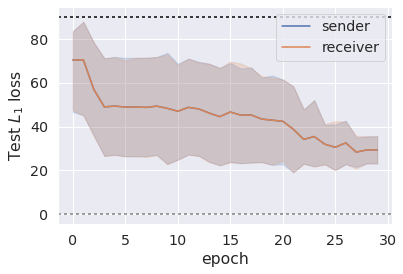

Bias 3


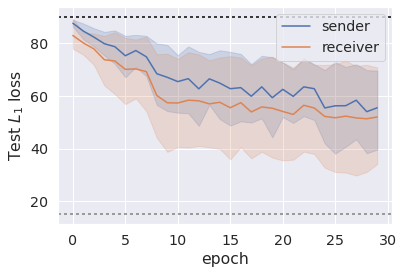

Bias 6


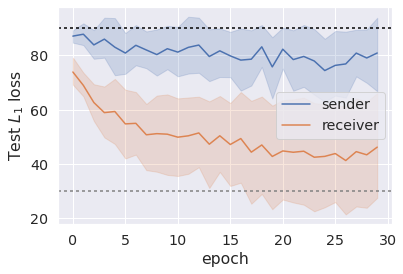

Bias 9


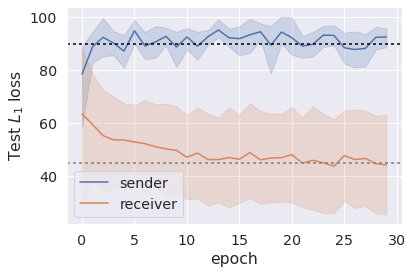

Bias 12


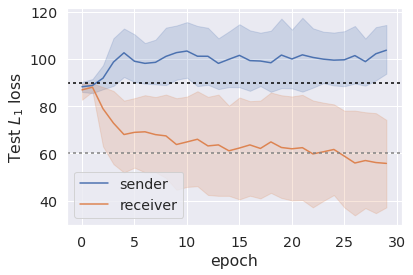

Bias 15


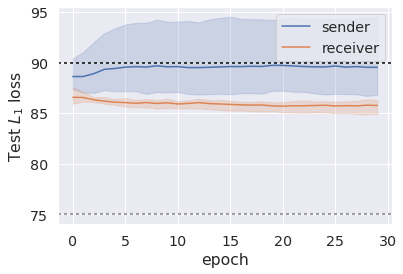

All Biases


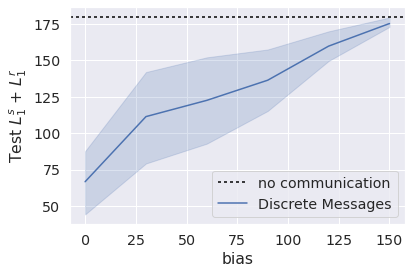

<Figure size 432x288 with 0 Axes>

In [4]:
resultspath = result_dir / 'gauss-deter-exp-nograd'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(resultspath, 'Discrete Messages', resultspath / 'plots')

Bias 0


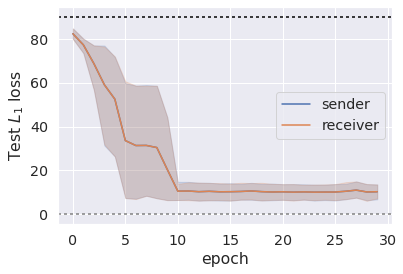

Bias 3


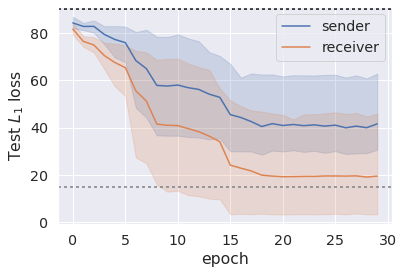

Bias 6


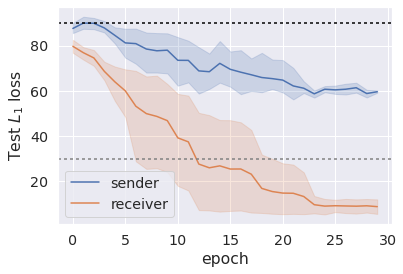

Bias 9


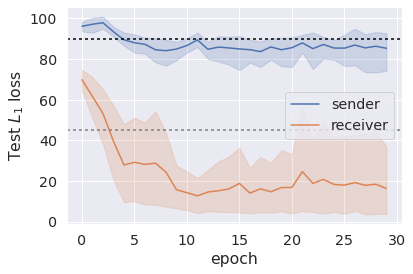

Bias 12


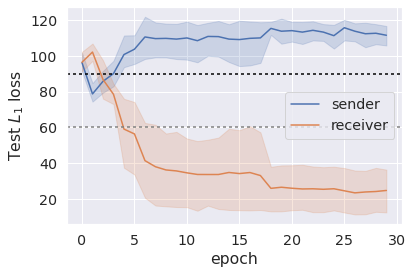

Bias 15


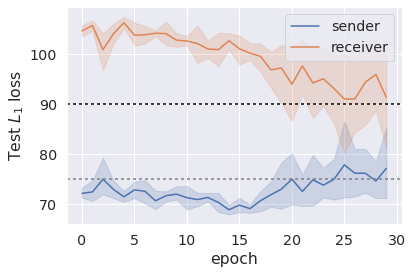

All Biases


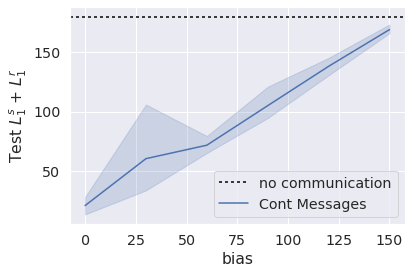

<Figure size 432x288 with 0 Axes>

In [5]:
resultspath = result_dir / 'gauss-deter-dim64'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(resultspath, 'Cont Messages', resultspath / 'plots')

Bias 0


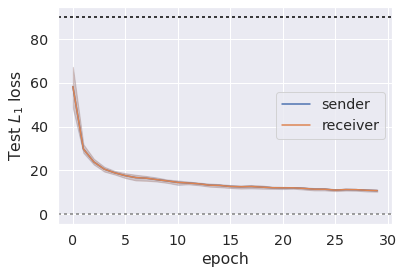

Bias 3


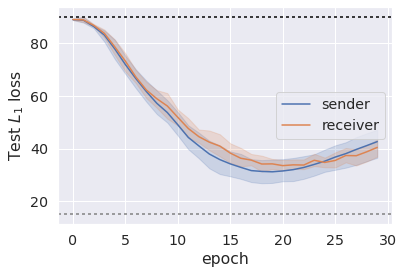

Bias 6


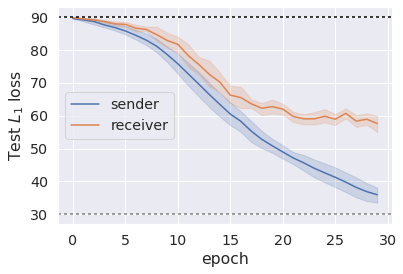

Bias 9


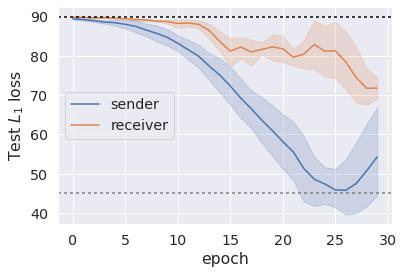

Bias 12


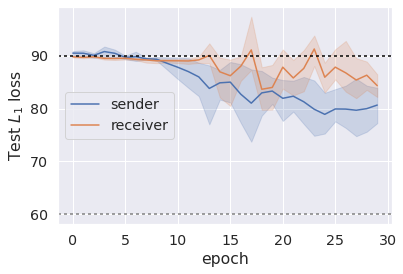

Bias 15


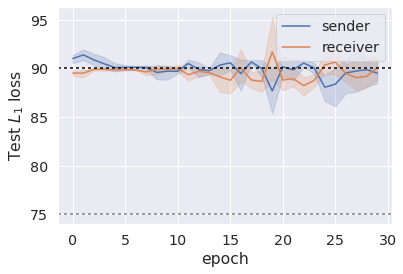

All Biases


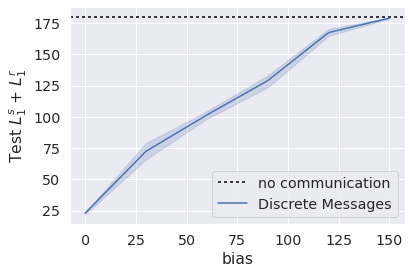

<Figure size 432x288 with 0 Axes>

In [60]:
# Discrete Messages


resultspath = result_dir / 'cat-deter'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(resultspath, 'Discrete Messages', resultspath / 'plots')

    

Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
All Biases
Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
All Biases


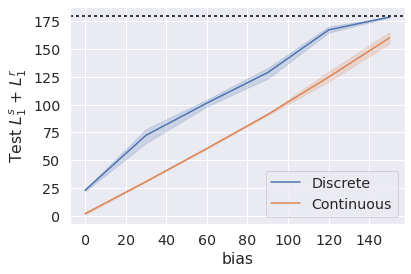

In [62]:
## Continuous v Discrete 

discrete_path = result_dir / 'cat-deter'
cont_path = result_dir / 'gauss-deter'

with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    label='Discrete'
    plot_hyperparam_results(discrete_path, label, discrete_path / 'plots', show=False)
    
    label='Continuous'
    plot_hyperparam_results(cont_path, label, cont_path / 'plots', show=False)

    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/discrete-v-continuous.png',  bbox_inches='tight')

Bias 0


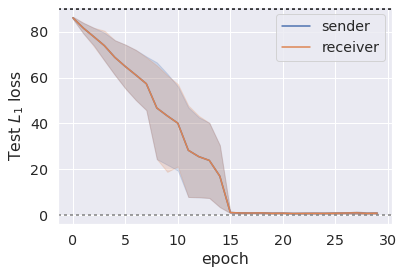

Bias 3


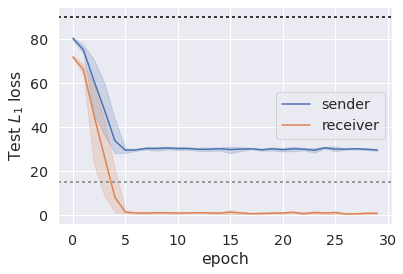

Bias 6


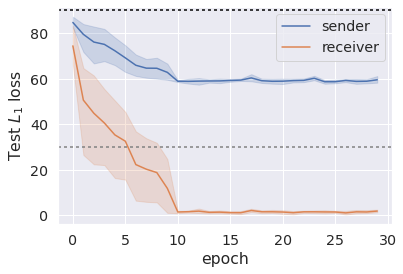

Bias 9


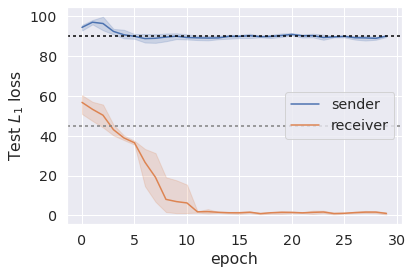

Bias 12


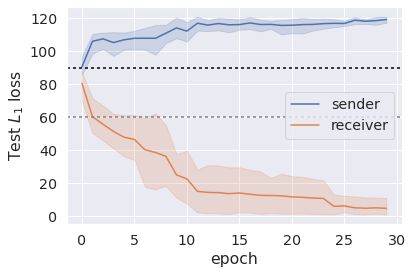

Bias 15


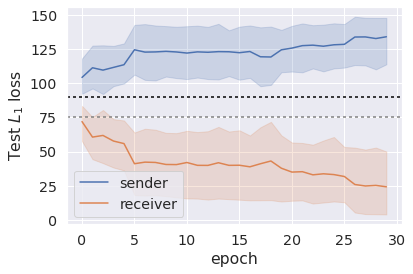

All Biases


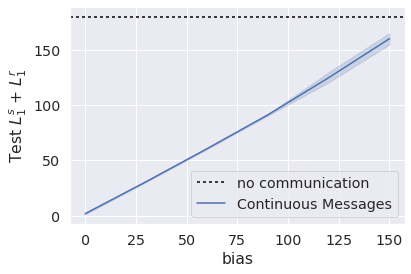

<Figure size 432x288 with 0 Axes>

In [63]:
## Continuous

resultspath = result_dir / 'gauss-deter'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'Continuous Messages', resultspath / 'plots')

In [13]:
## ENTROPY
def plot_entropies(results_dir, label='', savepath=None, show=True):
    results_path = Path(results_dir)
    
    results = []
    for result_folder in results_path.iterdir():
        if not result_folder.is_dir():
            continue
        
        folder_name = result_folder.name
        
        if not 'bias' in folder_name:
            continue
        
        bias_index = folder_name.index('bias') + 4
        if int(folder_name[bias_index]) in [0,3,6,9]:
            bias = int(folder_name[bias_index])
        elif int(folder_name[bias_index]) == 1 and int(folder_name[bias_index+1]) in [2,5,8]:
            bias = int(folder_name[bias_index:bias_index+2])
        else:
            raise Exception(f'couldnt figure out bias of {folder_name}')
        
        results.append({
            'bias': bias,
            'name': f'{label}-bias{bias}',
            'path': result_folder,
        })
    
    df = pd.DataFrame()
    
    last_entropies = []
    for bias_result in sorted(results, key=itemgetter('bias')):
        bias = bias_result['bias']
        folder_path = bias_result['path']
        name = bias_result['name']

#         try:
        print(f'Bias {bias}')
        seed_scores = entropy(folder_path, None, name, show=show, verbose=False, label=label)  
        for score in seed_scores:
            df = df.append({**bias_result, 'seed_score':score}, ignore_index=True)
#         entropy(folder_path, savepath, name, last_epochs=last_epochs, show=show, verbose=False)  
#             for score in seed_scores:
#                 df = df.append({**bias_result, 'seed_score':score}, ignore_index=True)
#         except Exception as e:
#             print(f'In {folder_path.name} error for bias {bias}')
#             print(f'Exception {e}')  
    
   
    plt.title("Entropy over Bias")
    if show:
        plt.show()
        
    print(f'Entropy vs Bias')
    if label == 'discrete':
        min_entropy = 0
        max_entropy = torch.log2(torch.tensor([256.])).item()
        sns.lineplot(data=df, x=df['bias']*10, y=(df['seed_score']), label=label)
    elif label == 'continuous':
        min_entropy = -15
        max_entropy = 15
        sns.lineplot(data=df, x=df['bias']*10, y=(df['seed_score'] - min_entropy) * 8/(max_entropy - min_entropy), label=label)

    
#     plt.axhline(min_entropy, label='min entropy', color="black", dashes=(2,2,2,2))
#     plt.axhline(max_entropy, label='max entropy', color="grey", dashes=(2,2,2,2))

    plt.ylabel('Scaled Entropy')
    plt.legend()
#     if savepath is not None:
#         savepath.mkdir(exist_ok=True)
#         plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
#     if show:
#         plt.show()
#         plt.clf()
    
#     return df

def entropy(logdir, savedir=None, name='error', show=True, verbose=True, label=None):

# logdir = Path('/home/mnoukhov/emergent-compete/results/cat-deter/cat-deter-bias0_f69b2c2613fa511b163a45563c110e4e')
# savedir = None
# name = 'entropy'
# verbose = True
# show = False

    # if savedir:
    #     savepath = Path(savedir)
    #     savepath.mkdir(exist_ok=True)

    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    if verbose:
        print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)

    bias = gin.config.query_parameter('Game.bias')
#     num_points = gin.config.query_parameter('Game.num_points')
    num_epochs = gin.config.query_parameter('train.num_epochs')
#     test_loss = CircleL1(num_points)

    run_logs = []
    for path in logpath.glob('**/*.json'):
        if verbose:
            print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            try:
                new_log = pd.read_json(logfile)
            except:
                print(f'JSON error in log at {path}')
            else:
                run_logs.append(new_log)

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])

#     metric = "test_l1_error" if "test_l1_error" in sender else "test_error"

    # Rewards
    if show:
        plt.ylabel(r'Entropy')
        sns.lineplot(data=sender, x="epoch", y='test_entropy', label=f"bias {bias}")
#     sns.lineplot(data=recver, x="epoch", y='entropy', label="receiver")

#     Baselines
#     if label == 'discrete':
#         min_entropy = torch.tensor([0])
#         max_entropy = torch.log2(torch.tensor([256.]))
#     elif label == 'continuous':
#         min_entropy = -15
#         max_entropy = 15
    
#     plt.axhline(min_entropy, label='min entropy', color="black", dashes=(2,2,2,2))
#     plt.axhline(max_entropy, label='max entropy', color="grey", dashes=(2,2,2,2))

    

    if savedir:
        plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')

#     plt.show()
#     plt.clf()
    
    last_epochs = 10

    sender_entropy = pd.DataFrame(sender['test_entropy']).join(logs['epoch'])
    sender_last = sender_entropy[sender_entropy['epoch'] >= num_epochs - last_epochs]
    seed_entropies = [sender_last[i*last_epochs:(i+1)*last_epochs]['test_entropy'].mean() for i in range(5)]
    
    return seed_entropies



Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
Entropy vs Bias
Bias 0
Bias 3
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
Bias 15
Entropy vs Bias


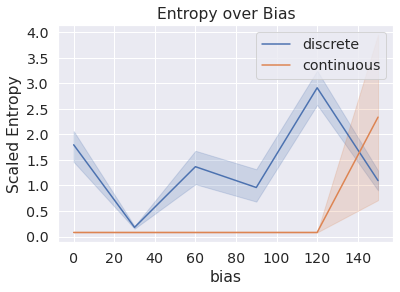

In [21]:
resultspath = result_dir / 'cat-deter-32768'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_entropies(result_dir / 'cat-deter', 'discrete', resultspath / 'plots', show=False)
    plot_entropies(result_dir / 'gauss-deter', 'continuous', resultspath / 'plots', show=False)

Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15


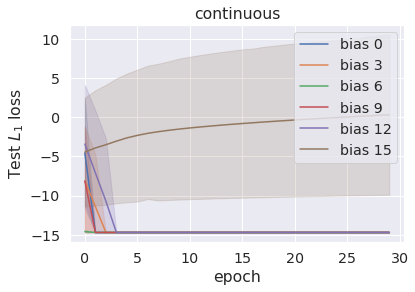

Entropy vs Bias


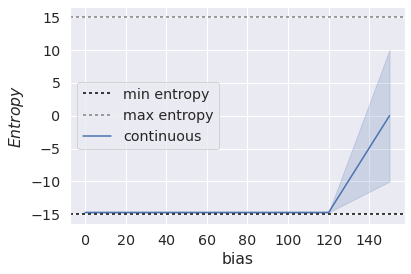

In [69]:
resultspath = result_dir / 'gauss-deter-ent100'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_entropies(resultspath, 'continuous', resultspath / 'plots')

Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15


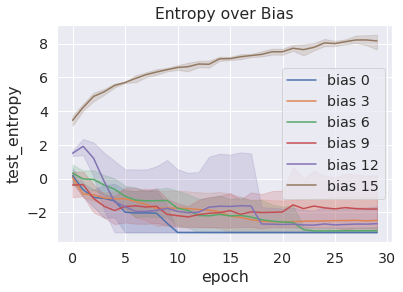

Entropy vs Bias


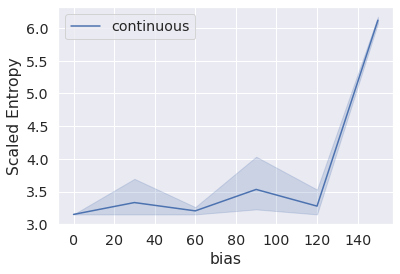

In [14]:
resultspath = result_dir / 'gauss-deter-dim64'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_entropies(resultspath, 'continuous', resultspath / 'plots')

In [24]:
import torch
from torch.distributions import Normal

In [34]:
x = torch.tensor([1.], requires_grad=True)
dist = Normal(0, x)
dist.entropy()
optimizer = torch.optim.SGD([x], lr=1)

In [36]:
optimizer.zero_grad()
loss = -dist.entropy() * 0.1
loss.backward()
optimizer.step()

In [37]:
x

tensor([1.1000], requires_grad=True)

config file /home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/0/config.gin
plotting from /home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/0/logs.json
plotting from /home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/1/logs.json
plotting from /home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/2/logs.json
plotting from /home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/3/logs.json
plotting from /home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/4/logs.json


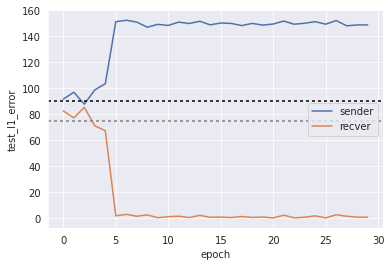

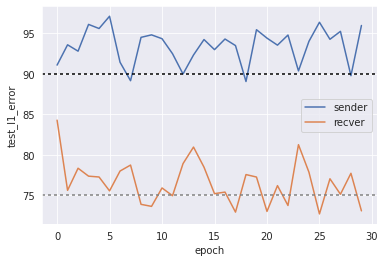

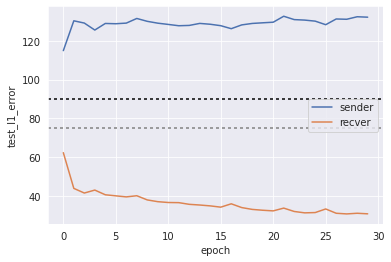

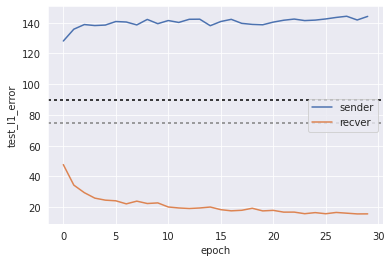

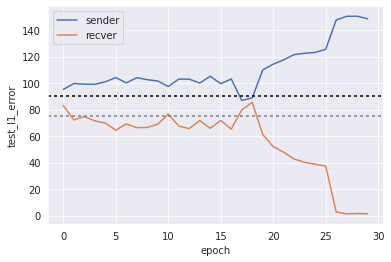

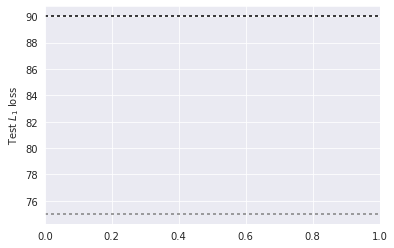

[15.113579547591508,
 16.96276593208313,
 16.26178710460663,
 15.867580366134643,
 15.868716630339623]

<Figure size 432x288 with 0 Axes>

In [87]:
plot('/home/mnoukhov/emergent-compete/results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/', individual_plot=True)

In [78]:
Path('/home/mnoukhov/emergent-compete/results').is_dir()

True

In [34]:
from torch.distributions import Normal
import math

In [35]:
means = torch.tensor([1.,2.,3.])
stds = torch.tensor([4.,5.,6.])

iso_mean = means.mean(dim=0, keepdim=True)
iso_std = stds.mean(dim=0, keepdim=True)

def cdf(value):
    return 0.5 * (1 + torch.erf((value - iso_mean) * iso_std.reciprocal() / math.sqrt(2)))

In [36]:
dists = [Normal(m,v) for m,v in zip(means,stds)]

In [41]:
print(cdf(99.0))
sum([dist.cdf(99.0) for dist in dists]) / 3

tensor([1.])


tensor(1.)